<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/Fall2025/Week10/intro_cnn_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device to be used: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]


CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

Epoch 1/5
Mini batch 1, Loss: 73.8450
Mini batch 101, Loss: 17.7991
Mini batch 201, Loss: 6.8068
Mini batch 301, Loss: 3.1049
Mini batch 401, Loss: 1.3558
Mini batch 501, Loss: 2.5292
Mini batch 601, Loss: 5.9670
Mini batch 701, Loss: 1.8303
Mini batch 801, Loss: 5.4996
Mini batch 901, Loss: 3.2065
Mini batch 1001, Loss: 3.3089
Mini batch 1101, Loss: 3.1852
Mini batch 1201, Loss: 6.5539
Mini

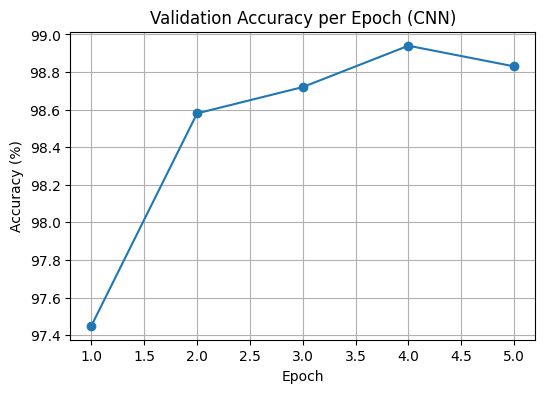

In [1]:
"""
This script demonstrates a simple Convolutional Neural Network (CNN) for
classifying MNIST handwritten digits using PyTorch.

Designed for teaching purposes to resemble examples from NVIDIA’s "Fundamentals of Deep Learning" training

Author: Dr. Olcay Kursun
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ------------------------------
# 1. Setup: random seeds and device
# ------------------------------
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device to be used:", device)

# ------------------------------
# 2. Load MNIST dataset
# ------------------------------
# Download training and test data (digits 0–9, 28x28 grayscale images)
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False)

# Define transformations (convert to tensor + small random rotation)
simple_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

train_dataset.transform = simple_transform
test_dataset.transform = simple_transform

# Wrap datasets into DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ------------------------------
# 3. Define the CNN model
# ------------------------------
# This CNN extracts spatial features via convolutional and pooling layers
# before using fully-connected layers for classification.

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # output: 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                             # output: 16x14x14
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # output: 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(2)                              # output: 32x7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)                           # 10 output classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNNModel().to(device)
print(model)

# ------------------------------
# 4. Loss function and optimizer
# ------------------------------
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------------
# 5. Training function (1 epoch)
# ------------------------------
def train_model():
    model.train()
    total_loss = 0
    batch = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Mini batch {batch+1}, Loss: {loss.item():.4f}")
        batch += 1

        total_loss += loss.item()

    print(f"Epoch average loss: {total_loss/len(train_dataset):.4f}")

# ------------------------------
# 6. Evaluation function
# ------------------------------
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# ------------------------------
# 7. Run training and evaluation
# ------------------------------
num_epochs = 5
accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_model()
    accuracy = evaluate_model(model)
    accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.2f}%")

# ------------------------------
# Plot accuracies
# ------------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), accuracies, marker='o')
plt.title("Validation Accuracy per Epoch (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()
